<a href="https://colab.research.google.com/github/EAkeweje/Accelerating-Hydrogen-Oxidation-Calculations/blob/main/Inference_RNN%20(Exclusion%20of%20H2%20and%20O2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import PIL
import pandas as pd
from tqdm.notebook import tqdm
import json
import time
import cv2
import random
import glob
import os
import copy
from sklearn.metrics import r2_score

## Utils

In [5]:
#Dataset object
class OxidationDataset(Dataset):

    def __init__(self, inputs_path, outputs_dir, nsample, ntimesteps, exclude_h2_o2 = False):
        """
        Args:
            inputs_dir (string): 
            outputs_dir (string):
        """
        
        # x = np.loadtxt(inputs_path, skiprows = 1, delimiter= ',')
        # x = np.loadtxt(inputs_path, delimiter= ' ')
        with open(inputs_path, 'rb') as f:
          x = np.load(f)
        self.exclude = exclude_h2_o2
        #drop inert gases
        if not self.exclude:
          self.inputs = np.delete(x[ :nsample, :], [8,9], 1)[:, np.newaxis]
        else:
          self.inputs = np.delete(x[ :nsample, :], [0, 3, 8, 9], 1)[:, np.newaxis]
        self.out_dir = outputs_dir
        self.ntimesteps = ntimesteps


    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        #get output
        # Y = np.loadtxt(os.path.join(self.out_dir, f'out{idx}.txt'), delimiter= ';')
        with open(os.path.join(self.out_dir, f'out{idx}.npy'), 'rb') as f:
          Y = np.load(f)

        #drop inert gases
        if type(self.ntimesteps) == int:
            Y = Y[:self.ntimesteps, 1:-2]
        elif type(self.ntimesteps) == list:
            Y = Y[self.ntimesteps, 1:-2]
        elif self.ntimesteps == 'all':
            Y = Y[:, 1:-2]
        else:
            raise ValueError("Invalid argument 'ntimestep' should an interger, a list or 'all' string")

        if self.exclude:
          Y = np.delete(Y, [1,4], axis = 1)

        return torch.from_numpy(self.inputs[idx]), torch.from_numpy(Y)

In [6]:
#for data standardization
def standardize(tensor, dim = 0, mean = None, std = None) -> torch.float64:
    tensor = tensor.float()

    if mean is None:
        mean = tensor.mean(dim = dim, keepdim = True)

    if std is None:
        std = tensor.std(dim = dim, keepdim = True)

    standard_tensor = (tensor - mean) / std
    return standard_tensor, mean, std

def inverse_standardize(tensor, dim, mean, std):
    tensor = tensor.float()
    return tensor * std + mean

In [7]:
def load_mean_std(path, loader = None):
  if os.path.exists(path):
    #get means and stds
    with open(path, 'r') as f:
        mean_std_dict = json.load(f)
    train_x_mean = torch.tensor(mean_std_dict['mean_x'])
    train_x_std = torch.tensor(mean_std_dict['std_x'])
    train_y_mean = torch.tensor(mean_std_dict['mean_y'])
    train_y_std = torch.tensor(mean_std_dict['std_y'])
    return train_x_mean, train_x_std, train_y_mean, train_y_std
  else:
    return save_mean_std(loader, path, output = True)
  

In [8]:
def save_mean_std(loader, path, output = False):
  '''
  loader:: preferably train loader
  path:: a json path
  output:: bool: to output the means and stds
  '''
  #obtaining mean and std of training set
  train_x = []
  train_y = []
  for x,y in loader:
      train_x.append(x)
      train_y.append(y)

  _, train_x_mean, train_x_std = standardize(torch.concat(train_x), 0)
  _, train_y_mean, train_y_std = standardize(torch.concat(train_y), 0)

  #write to disc
  mean_std_dict = {
      'mean_x' : train_x_mean.tolist(),
      'mean_y' : train_y_mean.tolist(),
      'std_x' : train_x_std.tolist(),
      'std_y' : train_y_std.tolist()
  }

  with open(path, 'w') as f:
    json.dump(mean_std_dict, f)
  
  if output:
    return train_x_mean, train_x_std, train_y_mean, train_y_std

In [9]:
###Networks
#single step
class RNN_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN_Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(self.input_size, self.hidden_size, self.num_layers, dropout = 0.1, batch_first = True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.linear(out)
        return out
    
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_uniform_(m.weight, nonlinearity= 'relu')
        m.bias.data.fill_(0.0)

###multiple time steps
#one to many RNN architechture
class Base_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(Base_RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(self.input_size, self.hidden_size, self.num_layers, dropout = 0.1, batch_first = True)
        self.linear = nn.Linear(self.hidden_size, self.input_size)
        
    def forward(self, x, in_hidden = None):
        if in_hidden == None:
            out, out_hidden = self.rnn(x)
        else:
            out, out_hidden = self.rnn(x, in_hidden)
        out = self.linear(out)
        return out, out_hidden

class RNN_Model_Multiple(nn.Module):
    def __init__(self,input_size, hidden_size, num_layers, output_size, ntimesteps):
        super(RNN_Model_Multiple, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.ntimesteps = ntimesteps
        self.base_rnn = Base_RNN(self.input_size, self.hidden_size, self.num_layers)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(self.input_size, self.output_size)
        
    def forward(self, x):
        out = x
        hidden = None
        
        #to store outputs
        outputs = []
        
        for t in range(self.ntimesteps):                
            #pass to rnn
            out, hidden = self.base_rnn(out, hidden)
            #pass to output layer
            outputs.append(self.linear(self.relu(out)))
            #skip connection
            out += x

        return torch.concat(outputs, 1)

#one to many RNN architechture
class Base_RNN_v2(nn.Module):
    def __init__(self, output_size, hidden_size, num_layers):
        super(Base_RNN_v2, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(self.output_size, self.hidden_size, self.num_layers, dropout = 0.1, batch_first = True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x, in_hidden = None):
        if in_hidden == None:
            out, out_hidden = self.rnn(x)
        else:
            out, out_hidden = self.rnn(x, in_hidden)
        out = self.linear(out)
        return out, out_hidden

class RNN_Model_Multiple_v2(nn.Module):
    def __init__(self,input_size, hidden_size, num_layers, output_size, ntimesteps):
        super(RNN_Model_Multiple_v2, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.ntimesteps = ntimesteps
        self.base_rnn = Base_RNN_v2(self.output_size, self.hidden_size, self.num_layers)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(self.input_size, self.output_size)

    def forward(self, x):
        #pass to first layer and activation
        x = self.relu(self.linear(x))

        #to store outputs
        outputs = []

        #set inputs to first RNN layer
        out = x
        hidden = None

        #loop through rnn layers
        for t in range(self.ntimesteps):                
            #pass to rnn
            out, hidden = self.base_rnn(out, hidden)
            #pass to output layer
            outputs.append(out)
            #skip connection
            out += x

        return torch.concat(outputs, 1)

In [10]:
def make_dataloaders(config, exclude_h2_o2 = False):
    '''
    batch_size: int = batch size
    ntimesteps: int or list = number/list of time steps in data
    nsample: int = number of samples to use
    split: list = list of train set to data ration and train+valid set to data ratio
    '''
    #initialize dataset object
    dataset = OxidationDataset(inputs_path = 'input_98660.npy',#'input_98660.txt',
                               outputs_dir = './Out_files_npy',
                               nsample = config['nsample'],
                               ntimesteps = config['timesteps'],
                               exclude_h2_o2 = exclude_h2_o2)
    # Creating Training, Validation, and Test dataloaders
    # split Train : Val : Test = 0.7 : 0.2 : 0.1
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    train_split = int(np.floor(config['split'][0] * dataset_size))
    val_split = int(np.floor(config['split'][1] * dataset_size))
    shuffle_dataset = True
    random_seed = 42
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices = indices[ : train_split]
    val_indices = indices[train_split : train_split + val_split]
    test_indices = indices[train_split + val_split : ]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    train_loader = DataLoader(dataset, batch_size = config['batch_size'], sampler=train_sampler)
    validation_loader = DataLoader(dataset, batch_size = config['batch_size'], sampler=valid_sampler)
    test_loader = DataLoader(dataset, batch_size = config['batch_size'], sampler=test_sampler)
    
    return train_loader, validation_loader, test_loader

def to_device(model, train_x_mean, train_x_std, train_y_mean, train_y_std):
  if torch.cuda.is_available():
    model = model.cuda()
    train_x_mean = train_x_mean.cuda()
    train_x_std = train_x_std.cuda()
    train_y_mean = train_y_mean.cuda()
    train_y_std = train_y_std.cuda()

#Inference
## Inference Utils

In [11]:
def get_total_material(Pressure, Temp):
  R = 8.31441642554361
  return Pressure / (R * Temp)

#compute O2 and H2
def get_total_H_O_init(input):
  '''
  Computes the total material (moles) of Hydrogen and Oxygen at initiation.
  input: proportion
  '''
  assert input.ndim < 4, f'Tensor dimension must be less than 4: got {input.ndim}'

  if input.ndim == 1:
    T_H = 2*input[0] + input[1] + input[4]+ 2*input[5] + input[6]+ 2*input[7]
    T_O = input[2] + 2*input[3] + input[4]+ input[5] + 2*input[6]+ 2*input[7]

  elif input.ndim == 2:
    T_H = 2*input[:,0] + input[:,1] + input[:,4]+ 2*input[:,5] + input[:,6]+ 2*input[:,7]
    T_O = input[:,2] + 2*input[:,3] + input[:,4]+ input[:,5] + 2*input[:,6]+ 2*input[:,7]

  elif input.ndim == 3:
    T_H = 2*input[:,:,0] + input[:,:,1] + input[:,:,4]+ 2*input[:,:,5] + input[:,:,6]+ 2*input[:,:,7]
    T_O = input[:,:,2] + 2*input[:,:,3] + input[:,:,4]+ input[:,:,5] + 2*input[:,:,6]+ 2*input[:,:,7]
  
  return T_H, T_O

def get_total_H_O_fit(input):
  '''
  Computes the total material (moles) of Hydrogen and Oxygen in model prediction.
  input: concentration
  '''
  assert input.ndim < 4, f'Tensor dimension must be less than 4: got {input.ndim}'

  if input.ndim == 1:
    T_H = input[1] + input[3]+ 2*input[4] + input[5]+ 2*input[6]
    T_O = input[2] + input[3]+ input[4] + 2*input[5]+ 2*input[6]

  elif input.ndim == 2:
    T_H = input[:,1] + input[:,3]+ 2*input[:,4] + input[:,5]+ 2*input[:,6]
    T_O = input[:,2] + input[:,3]+ input[:,4] + 2*input[:,5]+ 2*input[:,6]

  elif input.ndim == 3:
    T_H = input[:,:,1] + input[:,:,3]+ 2*input[:,:,4] + input[:,:,5]+ 2*input[:,:,6]
    T_O = input[:,:,2] + input[:,:,3]+ input[:,:,4] + 2*input[:,:,5]+ 2*input[:,:,6]
  
  return T_H, T_O

In [12]:
def prediction(input, target):
  '''
  Make predictions.
  inputs::: 
        tensor of input(s) and target(s)
  returns:::
        tensors of model prediction(s) and target(s)
  '''

  assert input.ndim == 3, f'Input must have 3 dimensions. Current input tensor has {input.ndim} dimensions'
  if target.ndim !=3:
    target = target.unsqueeze(0)

  #Total amount
  total_amount = get_total_material(input[:,:, -2], input[:,:,-1])

  #Total amount of O and H
  T_H, T_O = get_total_H_O_init(input)
  T_H = T_H * total_amount
  T_O = T_O * total_amount

  #Get concentrations of O2 and H2 in target
  C_H2_target = target[:, :, 1]
  C_O2_target = target[:, :, 4]

  #Exclude O2 and H2 in input and target
  input = np.delete(input, [0,3], axis = 2)
  target = np.delete(target, [1,4], axis = 2)

  #transform (standardize) input
  input, _, _ = standardize(input, 0, mean_std[0], mean_std[1])

  #make prediction
  pred = model(input.float())

  #inverse transform is required. 
  #It makes nosense to compute amount of O and H with transformed data
  pred = inverse_standardize(pred, 0, mean_std[2], mean_std[3])

  #get amount of O and H in prediction
  T_H_fit, T_O_fit = get_total_H_O_fit(pred)

  #compute concentration of H2 and O2 for prediction
  C_O2 = 0.5*(T_O - T_O_fit)
  C_H2 = 0.5*(T_H - T_H_fit)

  #concatenate the concentrations with other predictions
  full_prediction = torch.concat((pred, C_H2.unsqueeze(dim = 2), C_O2.unsqueeze(dim = 2)), dim = 2)
  full_target = torch.concat((target, C_H2_target.unsqueeze(dim = 2), C_O2_target.unsqueeze(dim = 2)), dim = 2)

  return full_prediction, full_target

In [13]:
def show_plots(predict, target, idx = 0):
  '''
  predict::: tensor of predictiions
  target::: tensor of targets
  idx::: index of sample to plot. default = 0
  '''
  fig, ax = plt.subplots(3,3, figsize = (20,10))
  labels = ["T",	'H', 'O', 'OH',	'H2O',	'HO2',	'H2O2', 'H2', 'O2']
  for i in range(9):
      a,b = i//3, i%3
      A = predict[idx,:, i]
      A_true = target[idx,:, i]
      # ax[a,b].figure()
      ax[a,b].plot(A.detach().cpu(), '-r', label = 'prediction')
      ax[a,b].plot(A_true.detach().cpu(), '-g', label = 'groundtruth')
      ax[a,b].set_title(labels[i])
      ax[a,b].legend()
  # plt.legend()
  plt.show()

## Hyperparameters

In [14]:
# Config
config = dict(
    ## data
    batch_size = 32,
    timesteps = 'all',
    nsample = 1500,
    split = [0.7, 0.2, 0.1],
    mean_std_path = 'rnn_NoH2_O2_all_mean_std.json',
    ## model
    input_size = 8,
    hidden_size = 40,
    num_layers = 3,
    output_size = 7,
    ntimesteps = 201,
    ## training
    epochs = 500,
    optimizer = 'Adam',
    SGD_momentum = 0.9,
    beta1 = 0.85, 
    beta2 = 0.9,
    lr = 0.001,
    dict_path = 'rnn_NoH2_O2_all_WANDB.pth', #lr_momentum
    scheduling = True,
    mb_coeff = 0,
    model = 'v1'
    )

config

{'batch_size': 32,
 'timesteps': 'all',
 'nsample': 1500,
 'split': [0.7, 0.2, 0.1],
 'mean_std_path': 'rnn_NoH2_O2_all_mean_std.json',
 'input_size': 8,
 'hidden_size': 40,
 'num_layers': 3,
 'output_size': 7,
 'ntimesteps': 201,
 'epochs': 500,
 'optimizer': 'Adam',
 'SGD_momentum': 0.9,
 'beta1': 0.85,
 'beta2': 0.9,
 'lr': 0.001,
 'dict_path': 'rnn_NoH2_O2_all_WANDB.pth',
 'scheduling': True,
 'mb_coeff': 0,
 'model': 'v1'}

In [15]:
#hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mean_std_path = config['mean_std_path']
input_size = config['input_size']
output_size = config['output_size']
dict_path = config['dict_path']

#data
#prepare dataloaders
train_loader, val_loader, test_loader = make_dataloaders(config, False)
#obtaining mean and std of training set
train_x_mean, train_x_std, train_y_mean, train_y_std = load_mean_std(mean_std_path, train_loader)
mean_std = [train_x_mean.to(device), train_x_std.to(device), train_y_mean.to(device), train_y_std.to(device)]

#model
#initialize model
if config['model'] == 'v1':
    model = RNN_Model_Multiple(input_size, config['hidden_size'], config['num_layers'], output_size, config['ntimesteps'])
elif config['model'] == 'v2':
    model = RNN_Model_Multiple_v2(input_size, config['hidden_size'], config['num_layers'], output_size, config['ntimesteps'])
#load model parameters
model.load_state_dict(torch.load(config['dict_path'], map_location=torch.device('cpu')))
model = model.to(device)
model.eval()

RNN_Model_Multiple(
  (base_rnn): Base_RNN(
    (rnn): RNN(8, 40, num_layers=3, batch_first=True, dropout=0.1)
    (linear): Linear(in_features=40, out_features=8, bias=True)
  )
  (relu): ReLU()
  (linear): Linear(in_features=8, out_features=7, bias=True)
)

In [16]:
##NME
target_stack = []
predict_stack = []

for i, (input, target) in enumerate(test_loader):
  if torch.cuda.is_available():
    input, target = input.cuda(), target.cuda()
  
  #make prediction
  pred, target = prediction(input, target)

  #save prediction
  predict_stack.append(pred)
  target_stack.append(target)

error = torch.linalg.norm(torch.concat(target_stack) - torch.concat(predict_stack))/torch.linalg.norm(torch.concat(target_stack))
print(f'Normalized Error: {error}')

Normalized Error: 0.023554990172797677


In [17]:
r2_score(torch.concat(target_stack).flatten().detach().cpu().numpy(), torch.concat(predict_stack).flatten().detach().cpu().numpy())

0.9993741724288608

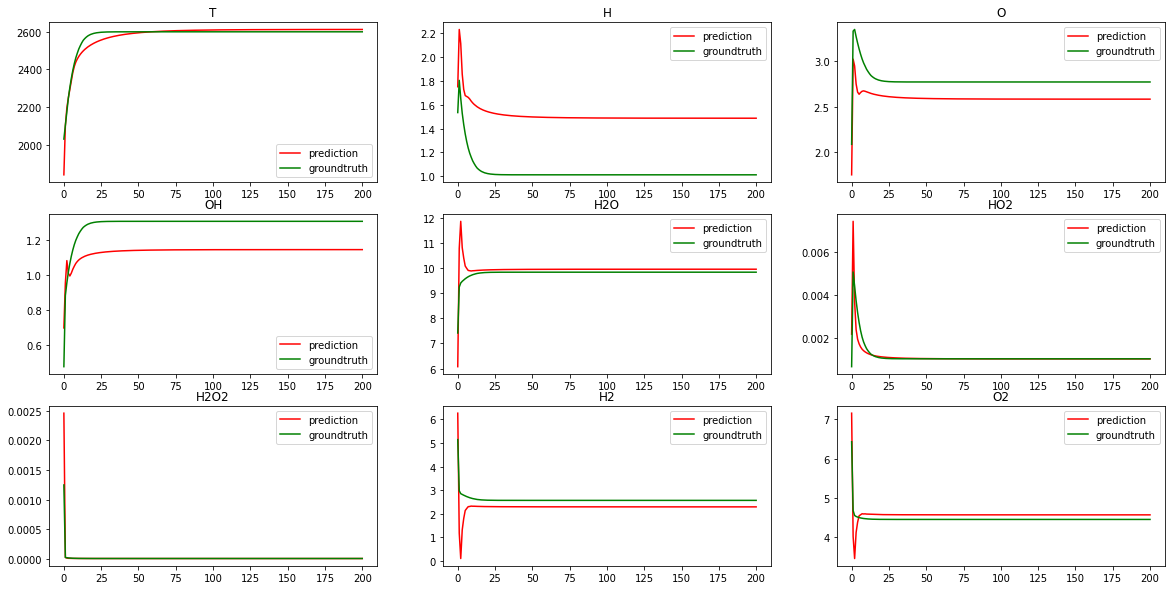

In [18]:
show_plots(torch.concat(predict_stack), torch.concat(target_stack), 138)

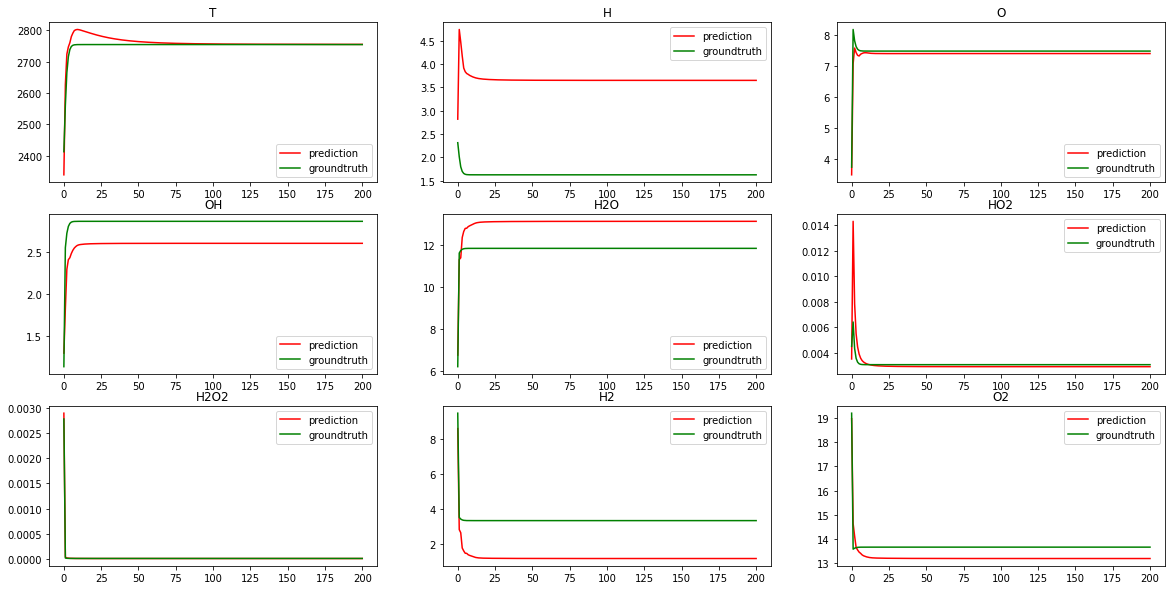

In [19]:
show_plots(torch.concat(predict_stack), torch.concat(target_stack),1)

### Inference on external **data**

In [20]:
input = torch.tensor([[[0.258059, 0.076098, 0.079991, 0.406154, 0.050154, 0.129445, 0.000035, 0.000065, 552392, 2869]]])
target =  torch.from_numpy(np.loadtxt('./Out_files_197/out0.txt', delimiter= ';')[:, 1:-2])

pred, target = prediction(input, target)
error = torch.linalg.norm(target - pred)/torch.linalg.norm(target)
print('Error = ', error.item())

Error =  0.012821599767218842


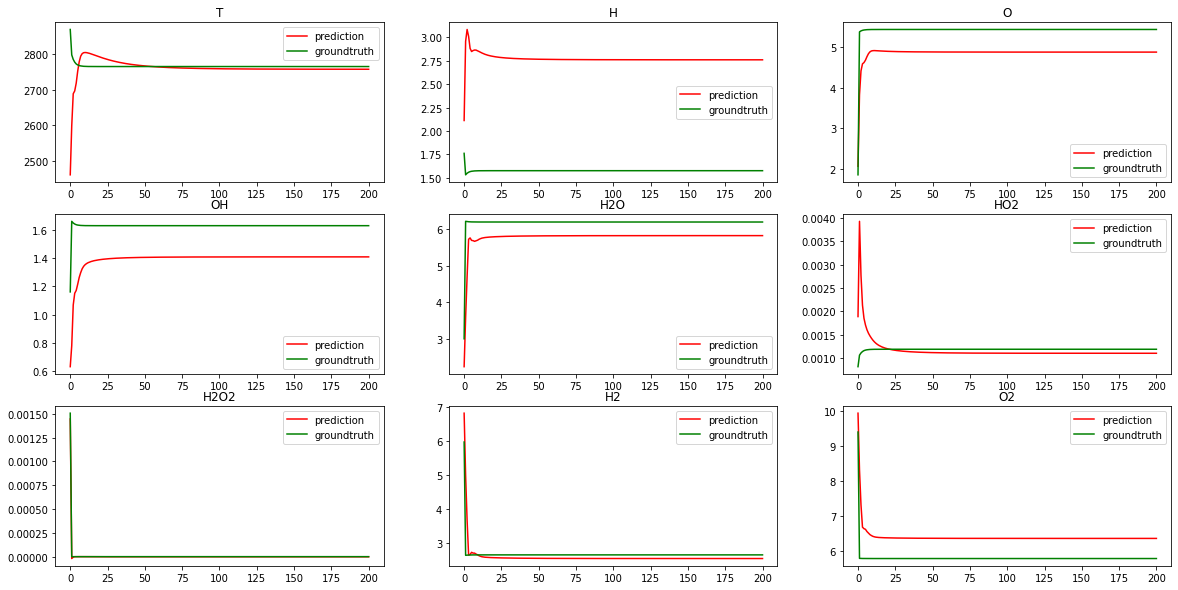

In [21]:
show_plots(pred, target)

In [22]:
input = torch.tensor([[[0.370668, 0.052756, 0.090097, 0.106036, 0.036734, 0.343536, 0.000104, 0.000068, 834259, 2874]]])
target =  torch.from_numpy(np.loadtxt('./Out_files_197/out10.txt', delimiter= ';')[:, 1:-2])

pred, target = prediction(input, target)
error = torch.linalg.norm(target - pred)/torch.linalg.norm(target)
print('Error =', error.item())

Error = 0.017627983905163104


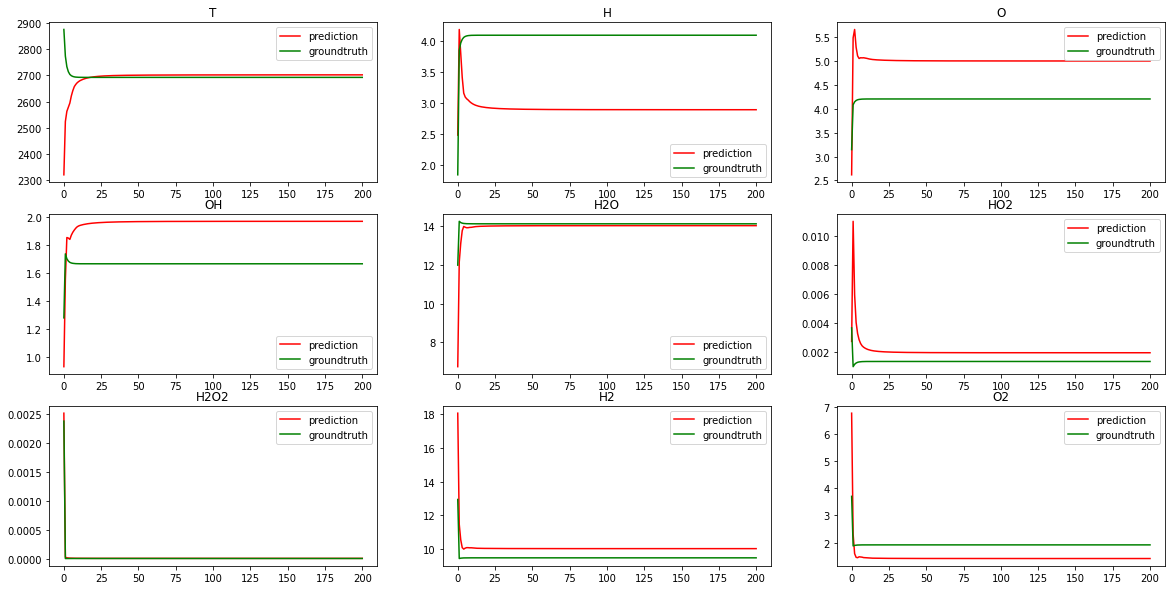

In [23]:
show_plots(pred, target)

#Comparing performance with model trained on all independent features

In [24]:
#load predictions of the other model
pred2 = torch.from_numpy(np.load('pred_test.npy'))

#reordering features to match
C_H2_ = pred2[:, :, 1]
C_O2_ = pred2[:, :, 4]
##Exclude O2 and H2
pred2_ = np.delete(pred2, [1,4], axis = 2)
## Concatenate H2 and O2
pred2 = torch.concat((pred2_, C_H2_.unsqueeze(dim = 2), C_O2_.unsqueeze(dim = 2)), dim = 2)
pred2.shape

torch.Size([1, 201, 9])

In [25]:
def show_plots_3(predict1, predict2, target):
  fig, ax = plt.subplots(3,3, figsize = (20,10))
  labels = ["T",	'H', 'O',	'OH',	'H2O',	'HO2',	'H2O2', 'H2', 'O2']
  for i in range(9):
    a,b = i//3, i%3
    A = predict1[0,:,i]
    A_ = predict2[0, :, i]
    A_true = target[0,:,i]
    # ax[a,b].figure()
    ax[a,b].plot(A.detach().cpu(), '-r', label = 'Exclude $H_2$ & $O_2$')
    ax[a,b].plot(A_.detach().cpu(), '-b', label = 'All independents')
    ax[a,b].plot(A_true.detach().cpu(), '-g', label = 'groundtruth')
    ax[a,b].set_title(labels[i])
    ax[a,b].legend()
  plt.show()

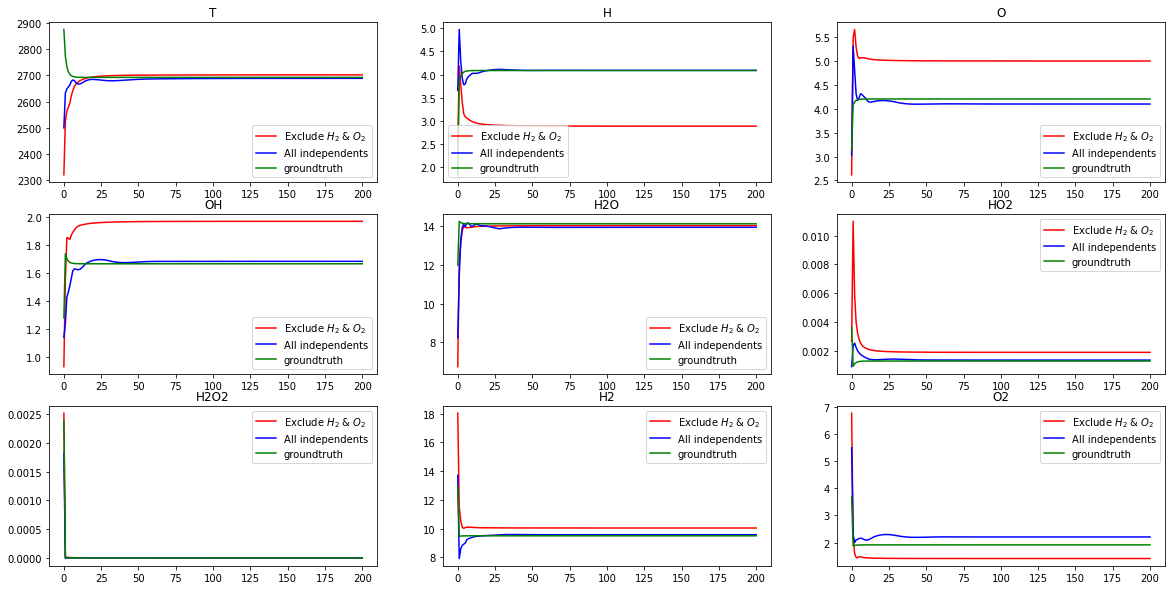

In [26]:
show_plots_3(pred, pred2, target)